In [1]:
from pathlib import Path
from tqdm import tqdm
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


ROOT_DIR = Path(os.getcwd()).parent

In [2]:
df: pd.DataFrame = pd.read_parquet(
    os.path.join(ROOT_DIR, "data/datasets/train_30_04.parquet")
)
df = df.reset_index(drop=True)

df["pump_hash"] = df["pumped_ticker"] + "_" + df["pump_time"]
df["is_pumped"].value_counts()

is_pumped
False    12070
True        85
Name: count, dtype: int64

<h4>Fill nans</h4>

In [3]:
df.isna().sum().sort_values(ascending=False).to_frame().head(40)

,0
quote_slippage_imbalance_ratio_1h_std_14d,3552
quote_slippage_imbalance_ratio_1h_std_7d,2268
quote_slippage_imbalance_ratio_1h_std_3d,1134
quote_slippage_imbalance_ratio_1h,1099
quote_slippage_imbalance_ratio_1h_mean_14d,984
quote_slippage_imbalance_ratio_1h_std_1d,488
imbalance_ratio_12h_auc,394
quote_slippage_imbalance_ratio_1h_mean_7d,361
quote_slippage_imbalance_ratio_3h,354
quote_slippage_imbalance_ratio_7h,116


In [4]:
reg_cols = df.columns[:-7]

In [5]:
cols_fill_median = [
    "daily_exchange_volume_share_3d_mean",
    "daily_exchange_volume_share_7d_mean",
    "daily_exchange_volume_share_14d_mean",
    "daily_exchange_volume_share_30d_mean",
    "daily_exchange_volume_share_30d_std",
    "daily_exchange_volume_share_3d_std",
    "daily_exchange_volume_share_14d_std",
    "daily_exchange_volume_share_7d_std",
]

# fill in nans with zeros for other cols
fillna_zeros_cols: List[str] = list(set(reg_cols) - set(cols_fill_median))

df[fillna_zeros_cols] = df[fillna_zeros_cols].fillna(0)

In [6]:
cols_fill_median = [
    "daily_exchange_volume_share_3d_mean",
    "daily_exchange_volume_share_7d_mean",
    "daily_exchange_volume_share_14d_mean",
    "daily_exchange_volume_share_30d_mean",
    "daily_exchange_volume_share_30d_std",
    "daily_exchange_volume_share_3d_std",
    "daily_exchange_volume_share_14d_std",
    "daily_exchange_volume_share_7d_std",
]

In [ ]:
# fill in nans with median values
df_features: pd.DataFrame = pd.DataFrame()

for (pumped_ticker, pump_time), df_pump in df.groupby(["pumped_ticker", "pump_time"]):
    pump_has_nans: bool = df_pump[df_pump["ticker"] == pumped_ticker][cols_fill_median].isna().any().any()

    if pump_has_nans:
        continue

    for col in cols_fill_median:
        df_pump[col] = df_pump[col].fillna(df_pump[col].median())

    df_features = pd.concat([df_features, df_pump])

df_features["is_pumped"].value_counts()

In [ ]:
df_pumps: pd.DataFrame = pd.DataFrame()

for i, (pump_hash, df_pump) in enumerate(df_features.groupby("pump_hash")):
    if i < 3:
        df_pumps = pd.concat([df_pumps, df_pump])

In [ ]:
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(30, 15))
axs = [el for ax in axs for el in ax]

for ax, col in tqdm(zip(axs, reg_cols[50:100]), total=len(reg_cols[50:100])):
    try:
        sns.histplot(
            data=df_pumps, x=col, hue="pump_hash", alpha=.3, legend=False, ax=ax, kde=True
        )
    except:
        pass
    
plt.tight_layout()
plt.show()

<h4>Apply crosssectional normalization</h4>

In [7]:
reg_cols = list(set(reg_cols) - set(cols_fill_median))

df_features = df.copy()

In [8]:
df_features_norm: pd.DataFrame = pd.DataFrame()
cols_to_standardize: List[str] = list(set(reg_cols) - set(["num_prev_pumps"]))

for pump_hash, df_pump in df_features.groupby("pump_hash"):
    for col in cols_to_standardize:
        df_pump[col] = (df_pump[col] - df_pump[col].mean()) / df_pump[col].std()

    df_features_norm = pd.concat([df_features_norm, df_pump])

d:\Pumps\env\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
d:\Pumps\env\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [9]:
df_train: pd.DataFrame = df_features_norm[
    df_features_norm["pump_time"] < "2021-05-01"
].copy()

df_test: pd.DataFrame = df_features_norm[
    df_features_norm["pump_time"] >= "2021-05-01"
].copy()

df_train["is_pumped"].value_counts(), df_test["is_pumped"].value_counts()

(is_pumped
 False    7911
 True       64
 Name: count, dtype: int64,
 is_pumped
 False    4159
 True       21
 Name: count, dtype: int64)

<h4>Train the model</h4>

In [10]:
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, KFold
from sklearn.metrics import f1_score, precision_recall_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from functools import partial
from catboost import Pool, CatBoostClassifier

import optuna
import gc

d:\Pumps\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<h4>Vanilla CatboostClassifier</h4>

In [33]:
train: Pool = Pool(data=df_train[reg_cols], label=df_train["is_pumped"], cat_features=["num_prev_pumps"])
test: Pool = Pool(data=df_test[reg_cols], label=df_test["is_pumped"], cat_features=["num_prev_pumps"])

model_baseline = CatBoostClassifier(
    objective="Logloss", iterations=200, verbose=100
)
model_baseline.fit(train)

y_proba: np.array = model_baseline.predict_proba(test)

Learning rate set to 0.100468
0:	learn: 0.4798480	total: 32ms	remaining: 6.36s
100:	learn: 0.0097077	total: 2.71s	remaining: 2.66s
199:	learn: 0.0038951	total: 5.22s	remaining: 0us


In [12]:
df_test["proba"] = y_proba[:, 1]

thresholds = range(1, 101)
baseline_top_k_vals = []

for K in thresholds: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    baseline_top_k_vals.append(
        sum(top_k) / len(top_k)
    )

auc(x=np.arange(0.01, 1.01, 0.01), y=baseline_top_k_vals)

0.7335714285714285

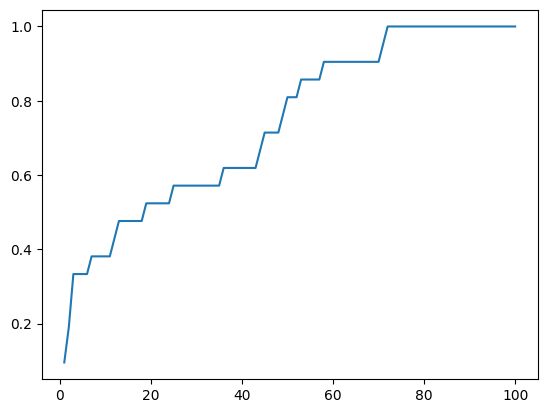

In [13]:
plt.plot(thresholds, baseline_top_k_vals)
plt.show()

<h4>Optimize for Top-K AUC</h4>

In [14]:
def calc_top_k_auc(df_test: pd.DataFrame, y_proba: np.array) -> Tuple[float, np.array]:
    """Returns the area under the TOP-K curve"""
    df_test: pd.DataFrame = df_test.copy()
    df_test["proba"] = y_proba

    thresholds = range(1, 101)
    top_k_vals = []

    for K in thresholds: 

        top_k: List[bool] = []

        for pump_hash, df_pump in df_test.groupby("pump_hash"):
            df_pump = df_pump.sort_values(by="proba", ascending=False)
            top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
            top_k.append(top_k_contains_pump)

        top_k_vals.append(
            sum(top_k) / len(top_k)
        )

    return auc(x=np.arange(0.01, 1.01, 0.01), y=top_k_vals), top_k_vals

In [15]:
def catboost_objective(
    trial: optuna.Trial, df: pd.DataFrame, reg_cols: List[str], target: str, fold: TimeSeriesSplit
) -> float:
    params = {
        "objective": "Logloss",
        "eval_metric": "Logloss",
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        "class_weights": [1, trial.suggest_float("scale_pos_weight", 1, 300)],
    }

    auc_scores = []
    
    i = 0
    
    for train_idx, val_idx in fold.split(df[reg_cols], df[target]):
        # split data to train and validation sets
        df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]
        # train on train subset and use validation set to evaluate the model
        train = Pool(data=df_train[reg_cols], label=df_train[target], cat_features=["num_prev_pumps"])
        val = Pool(data=df_val[reg_cols], label=df_val[target], cat_features=["num_prev_pumps"])
        
        # Fit the model with early stopping
        model = CatBoostClassifier(
            **params, 
            iterations=500,
            early_stopping_rounds=20,
            use_best_model=True,
            verbose=False
        )

        model.fit(train, eval_set=val)
        
        y_proba = model.predict_proba(val)[:, 1]
        top_k_auc, _ = calc_top_k_auc(df_test=df_val, y_proba=y_proba)
        
        # get the best auc_score validation set
        auc_scores.append(top_k_auc)
        
        trial.report(top_k_auc, i)

        if trial.should_prune():
            raise optuna.TrialPruned()
        
        del model, train, val
        _ = gc.collect()
        
        i += 1

    return np.mean(auc_scores)

In [ ]:
fold = TimeSeriesSplit(n_splits=5)

study_catboost = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
)

study_catboost.optimize(
    partial(catboost_objective, df=df_train, reg_cols=reg_cols, target="is_pumped", fold=fold), 
    n_trials=80
)

In [17]:
params = {
    "objective": "Logloss",
    # "task_type": "GPU"
}

cb_params = {
    "objective": "Logloss",
    # "task_type": "GPU"
}

cb_params.update(study_catboost.best_params)
cb_params["class_weights"] = [1, study_catboost.best_params["scale_pos_weight"]]

del cb_params["scale_pos_weight"]

cb_params

{'objective': 'Logloss',
 'learning_rate': 0.01249212495422191,
 'max_depth': 4,
 'class_weights': [1, 9.354446975442784]}

In [18]:
df_val = df_train[df_train["pump_time"] >= "2021-02-01"].copy()
df_train = df_train[df_train["pump_time"] < "2021-02-01"].copy()

df_train["is_pumped"].sum(), df_val["is_pumped"].sum()

(55, 9)

In [19]:
train: Pool = Pool(data=df_train[reg_cols], label=df_train["is_pumped"], cat_features=["num_prev_pumps"])
val: Pool = Pool(data=df_val[reg_cols], label=df_val["is_pumped"], cat_features=["num_prev_pumps"])

In [34]:
model = CatBoostClassifier(
    **cb_params,
    iterations=500,
    # early_stopping_rounds=20,
    # use_best_model=True,
    verbose=100
)
model.fit(
    train, 
    # eval_set=val
)

y_proba: np.array = model.predict_proba(test)[:, 1]

0:	learn: 0.6748484	total: 21.3ms	remaining: 10.6s
100:	learn: 0.1831575	total: 1.59s	remaining: 6.29s
200:	learn: 0.1226348	total: 3.14s	remaining: 4.68s
300:	learn: 0.0916314	total: 4.75s	remaining: 3.14s
400:	learn: 0.0701898	total: 6.51s	remaining: 1.61s
499:	learn: 0.0549715	total: 8.16s	remaining: 0us


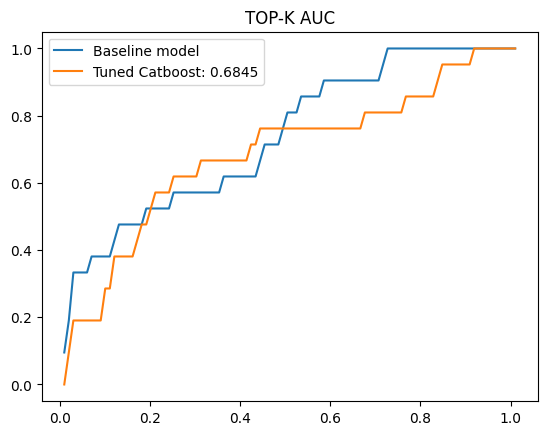

In [35]:
top_k_auc, top_k_vals = calc_top_k_auc(df_test, y_proba=y_proba)

plt.plot(np.linspace(0.01, 1.01, 100), baseline_top_k_vals, label="Baseline model")
plt.plot(np.linspace(0.01, 1.01, 100), top_k_vals, label=f"Tuned Catboost: {round(top_k_auc, 4)}")

plt.title("TOP-K AUC")
plt.legend()
plt.show()

In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

y_pred = (y_proba >= 0.1).astype(int)

print(classification_report(y_true=df_test["is_pumped"], y_pred=y_pred))

              precision    recall  f1-score   support

       False       1.00      0.97      0.98      4159
        True       0.02      0.14      0.04        21

    accuracy                           0.96      4180
   macro avg       0.51      0.55      0.51      4180
weighted avg       0.99      0.96      0.98      4180



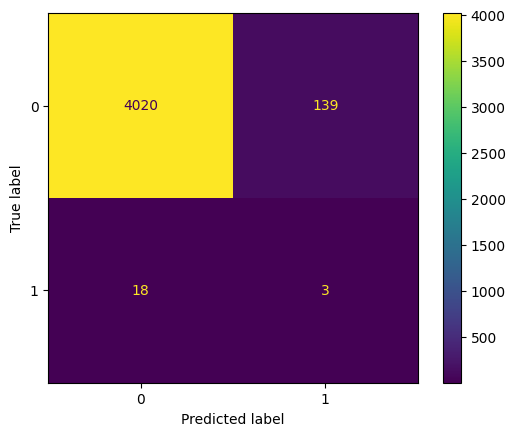

In [37]:
cm = confusion_matrix(y_pred=y_pred, y_true=df_test["is_pumped"])
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

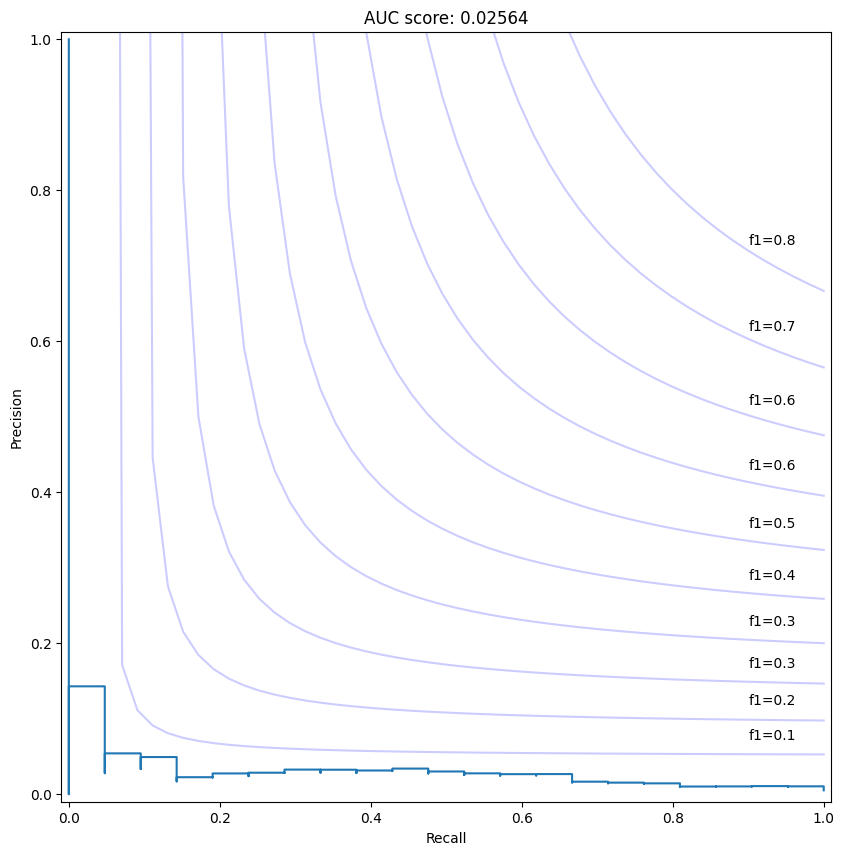

In [38]:
from sklearn.metrics import precision_recall_curve, auc, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(y_true=df_test["is_pumped"], probas_pred=y_proba)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

PrecisionRecallDisplay(
    precision=precision, recall=recall
).plot(ax=ax)

f_scores = np.linspace(0.1, 0.8, num=10)
lines, labels = [], []

for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = ax.plot(x[y >= 0], y[y >= 0], color="blue", alpha=0.2)
    ax.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

plt.title(f"AUC score: {round(auc(recall, precision), 5)}")
plt.show()

In [39]:
# TOP-K metric
df_test["proba"] = y_proba

top_k_vals = []

for K in [1, 5, 10, 20, 40, 60]: 

    top_k: List[bool] = []

    for pump_hash, df_pump in df_test.groupby("pump_hash"):
        df_pump = df_pump.sort_values(by="proba", ascending=False)
        top_k_contains_pump: bool = df_pump.iloc[:K]["is_pumped"].any()
        top_k.append(top_k_contains_pump)

    top_k_vals.append(
        sum(top_k) / len(top_k)
    )
        
top_k_vals

[0.0,
 0.19047619047619047,
 0.2857142857142857,
 0.5238095238095238,
 0.6666666666666666,
 0.7619047619047619]

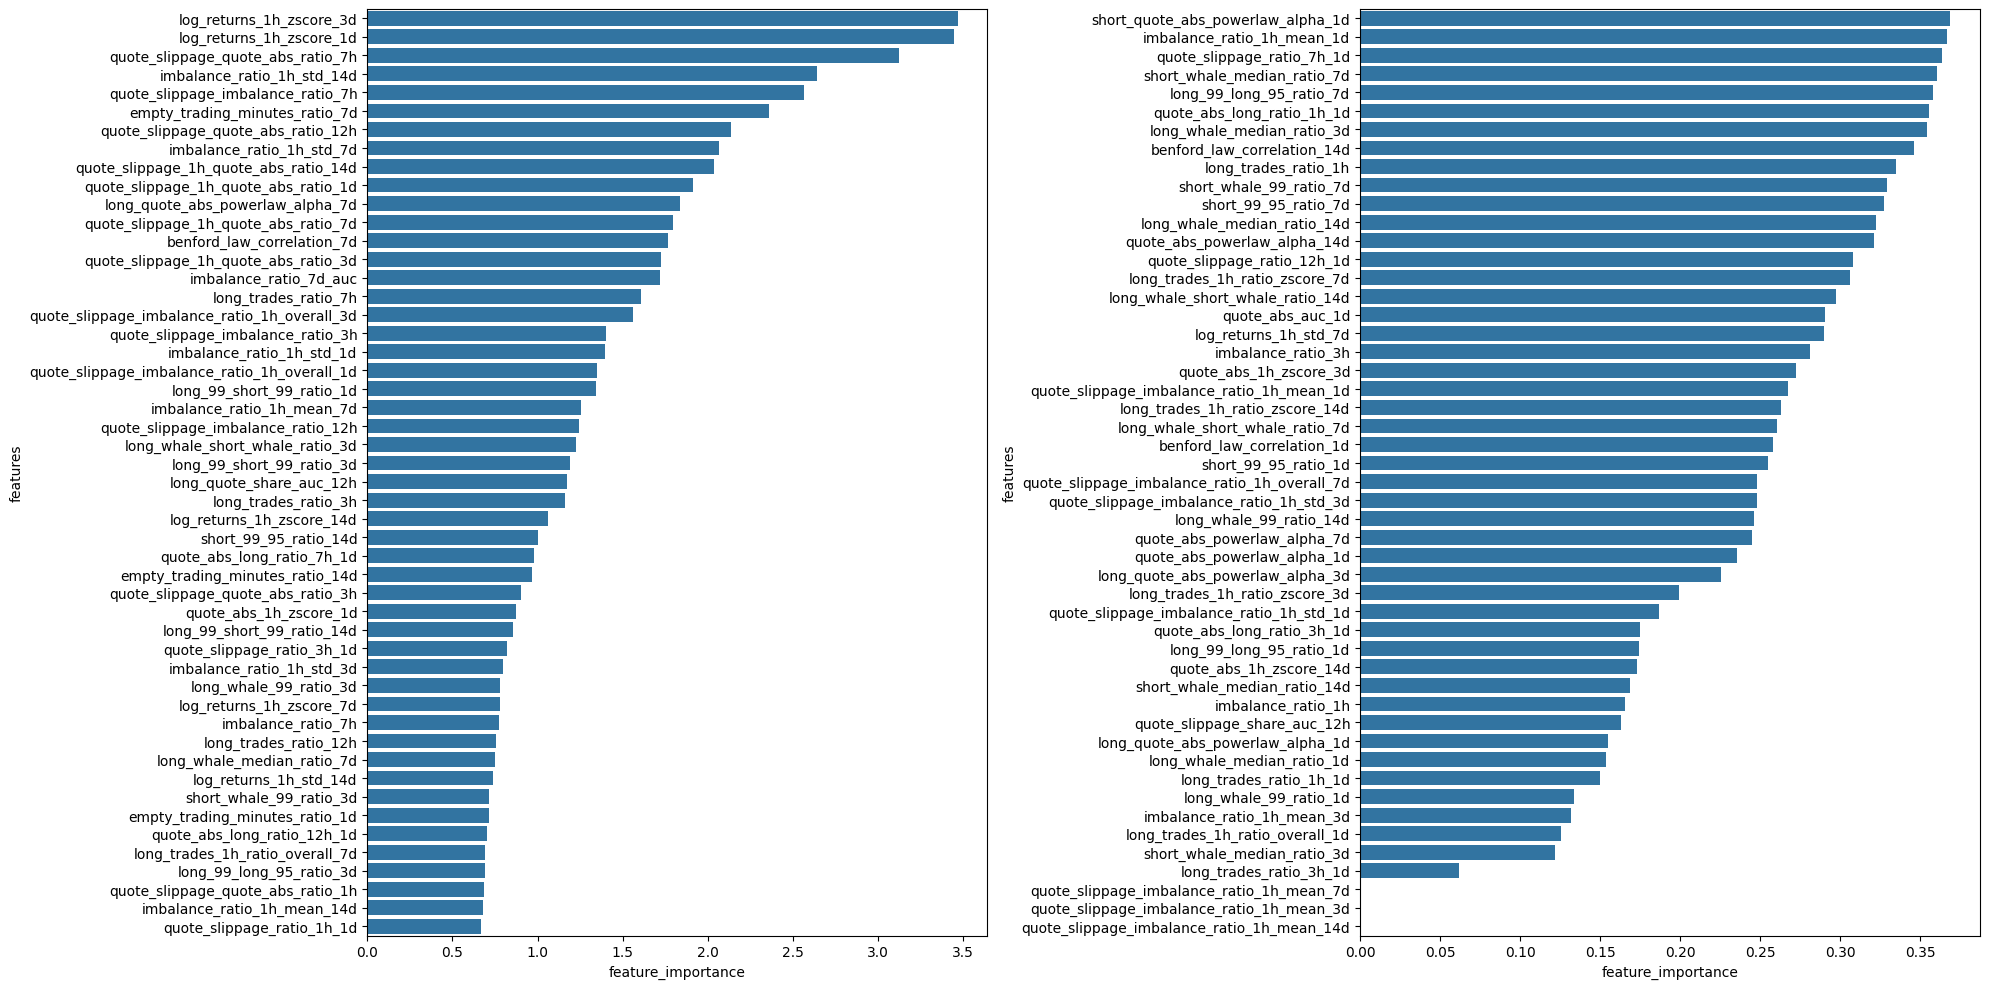

In [40]:
df_fi = pd.DataFrame({
    "features": reg_cols,
    "feature_importance": model.feature_importances_
})

df_fi = df_fi.sort_values(by="feature_importance", ascending=False)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ax1, ax2 = axs

sns.barplot(
    data=df_fi.iloc[:50], x="feature_importance", y="features", ax=ax1
)
sns.barplot(
    data=df_fi.iloc[-50:], x="feature_importance", y="features", ax=ax2
)

plt.tight_layout()
plt.show()